# Neural-Kernel model 

In [2]:
import importlib
import numpy as np
import pandas as pd
import torch
import model_functions
from model_functions import preprocess_diabetes, BottleneckMLP
importlib.reload(model_functions)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [3]:
file = 'data/diabetes.csv'

df = pd.read_csv(file)

prep_data = preprocess_diabetes(df)

df = prep_data["df"]
X_train = prep_data["X_train"]
X_test = prep_data["X_test"]
y_train = prep_data["y_train"]
y_test = prep_data["y_test"]
y_train_numeric = y_train.replace({"Malignant": 1, "Benign": 0}).astype(float)
y_test_numeric  = y_test.replace({"Malignant": 1, "Benign": 0}).astype(float)

Selected 18 features from 21 (threshold=0.05)


In [4]:
def hybrid_predict(model, svm, scaler, X_train, y_train, X_test):
    """
    Fit SVM on bottleneck features and predict on new data
    """

    # ---------- SCALE ----------
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # ---------- TORCH ----------
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)

    # ---------- BOTTLENECK ----------
    model.eval()
    with torch.no_grad():
        _, Z_train = model(X_train_tensor)
        _, Z_test  = model(X_test_tensor)

    Z_train_np = Z_train.numpy()
    Z_test_np  = Z_test.numpy()

    # ---------- FIT SVM ----------
    svm.fit(Z_train_np, y_train)

    # ---------- PREDICT ----------
    y_pred  = svm.predict(Z_test_np)
    y_proba = svm.predict_proba(Z_test_np)[:, 1]

    return y_pred, y_proba


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # NumPy
X_test_scaled  = scaler.transform(X_test)        # NumPy


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numeric, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [6]:
model = BottleneckMLP(input_dim=X_train_tensor.shape[1])
svm = SVC(kernel='linear', C=1, gamma='scale', probability=True)


In [22]:
y_pred, y_proba = hybrid_predict(
    model=model,
    svm=svm,
    scaler=scaler,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_test_tensor
)



/Users/tania_priv/Library/Python/3.11/lib/python/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/tania_priv/Library/Python/3.11/lib/python/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/tania_priv/Library/Python/3.11/lib/python/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


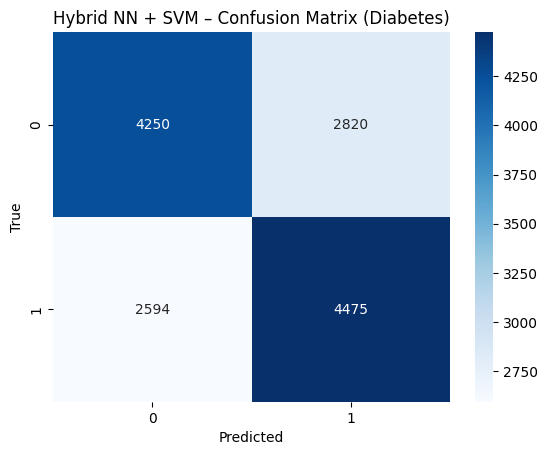

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Example
plot_confusion(y_test, y_pred, "Hybrid NN + SVM – Confusion Matrix (Diabetes)")


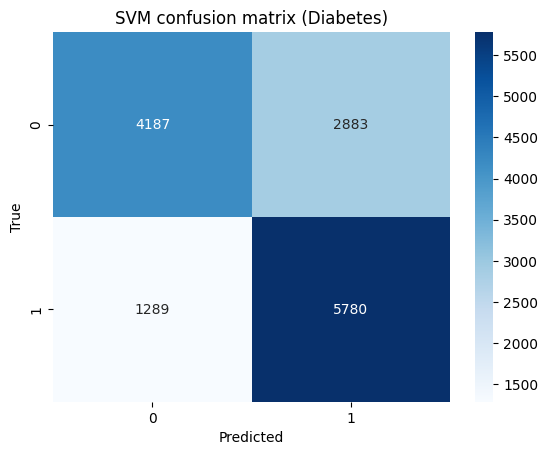

In [32]:
svm = SVC(
    kernel="poly",   # or "rbf", "poly"
    C=1.0,
    gamma='scale',
    probability=True,
    degree=2,
    random_state=42
)

svm.fit(X_train_scaled, y_train)

# -------------------------------
# 4. Predict
# -------------------------------
y_pred = svm.predict(X_test_scaled)

# -------------------------------
# 5. Confusion matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)

plot_confusion(y_test, y_pred, "SVM confusion matrix (Diabetes)")



In [29]:
fn_idx = (y_test_numeric == 1) & (y_pred == 0)
tp_idx = (y_test_numeric == 1) & (y_pred == 1)
feature_names = X_train.columns
import pandas as pd

X_fn = pd.DataFrame(
    X_test_tensor.detach().cpu().numpy()[fn_idx],
    columns=feature_names
)

X_tp = pd.DataFrame(
    X_test_tensor.detach().cpu().numpy()[tp_idx],
    columns=feature_names
)

X_fn.describe(), X_tp.describe()


(           genhlth       highbp          bmi     highchol          age  \
 count  2594.000000  2594.000000  2594.000000  2594.000000  2594.000000   
 mean      0.271041     0.277283     0.170106    -0.412420     0.199936   
 std       0.863149     0.923631     0.950567     0.934028     0.863958   
 min      -1.648180    -1.134869    -1.946466    -1.052422    -2.659676   
 25%       0.149098    -1.134869    -0.400907    -1.052422    -0.204950   
 50%       0.149098     0.881159     0.020609    -1.052422     0.145726   
 75%       1.047736     0.881159     0.582630     0.950189     0.847076   
 max       1.946375     0.881159     8.310426     0.950189     1.548427   
 
           diffwalk       income     physhlth  heartdiseaseorattack  \
 count  2594.000000  2594.000000  2594.000000           2594.000000   
 mean     -0.202866     0.073425     0.005252              0.109662   
 std       0.852788     0.950501     0.997555              1.098486   
 min      -0.580284    -2.162394    -0.

## Learning curves

In [1]:
import numpy as np
import torch
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

def hybrid_learning_curve(
    model_class,
    X,
    y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    bottleneck_dim=8,
    hidden_sizes=(64, 32),
    epochs=100,
    lr=0.001,
    random_state=42
):
    """
    Compute learning curve for Hybrid NN + SVM using recall.
    """

    # Fixed validation split
    X_train_full, X_val, y_train_full, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    recalls = []

    for frac in train_sizes:
        n_samples = int(len(X_train_full) * frac)

        # Subsample training data
        X_train = X_train_full[:n_samples]
        y_train = y_train_full[:n_samples]

        # ---------- SCALING (fit only on training subset) ----------
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # ---------- TORCH DATA ----------
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)

        # ---------- DEFINE MODEL ----------
        model = model_class(
            input_dim=X_train.shape[1],
            hidden_sizes=hidden_sizes,
            bottleneck_dim=bottleneck_dim
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.BCELoss()

        # ---------- TRAIN NN ----------
        for _ in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs, _ = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

        # ---------- EXTRACT BOTTLENECK FEATURES ----------
        model.eval()
        with torch.no_grad():
            _, Z_train = model(X_train_tensor)
            _, Z_val = model(X_val_tensor)

        # ---------- SVM ----------
        svm = SVC(kernel="linear", C=1, probability=True)
        svm.fit(Z_train.numpy(), y_train)

        y_pred = svm.predict(Z_val.numpy())

        # ---------- METRIC ----------
        recall = recall_score(y_val, y_pred)
        recalls.append(recall)

    return train_sizes, recalls


In [7]:
train_sizes, recalls = hybrid_learning_curve(
    model_class=BottleneckMLP,
    X=X_train.values,          # or numpy array
    y=y_train.values,          # encoded as 0/1
    train_sizes=np.linspace(0.1, 1.0, 5),
    epochs=100
)


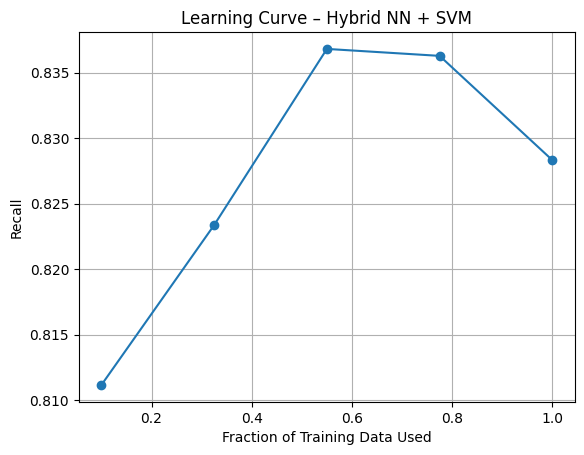

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_sizes, recalls, marker="o")
plt.xlabel("Fraction of Training Data Used")
plt.ylabel("Recall")
plt.title("Learning Curve – Hybrid NN + SVM")
plt.grid(True)
plt.show()


## Convergence plot

In [10]:
train_losses = []
epochs = []

model = BottleneckMLP(
    input_dim=X_train.shape[1],
    hidden_sizes=(64, 32),
    bottleneck_dim=8
)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    outputs, _ = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    epochs.append(epoch)


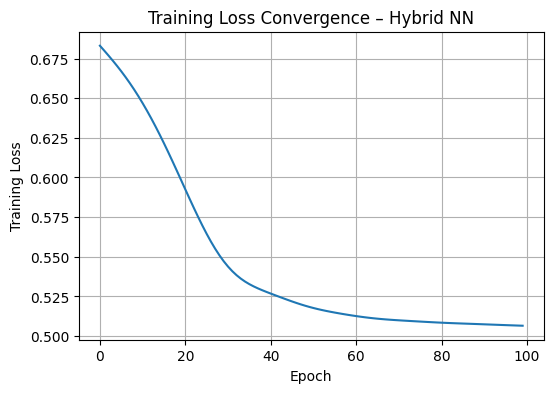

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Convergence – Hybrid NN")
plt.grid(True)
plt.show()
